In [6]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
from ddm.run_split import SplitMnistGenerator
from ddm.alg.vcl import run_vcl
from ddm.alg.coreset import rand_from_batch, k_center
from ddm.alg.utils import plot
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

Epoch: 0001 cost= 0.727379918
Epoch: 0006 cost= 0.022990299
Epoch: 0011 cost= 0.008503349
Epoch: 0016 cost= 0.005197641
Epoch: 0021 cost= 0.003914721
Epoch: 0026 cost= 0.002784967
Epoch: 0031 cost= 0.002196545
Epoch: 0036 cost= 0.001785548
Epoch: 0041 cost= 0.001417262
Epoch: 0046 cost= 0.001146567
Epoch: 0051 cost= 0.000900536
Epoch: 0056 cost= 0.000706360
Epoch: 0061 cost= 0.000542092
Epoch: 0066 cost= 0.000414987
Epoch: 0071 cost= 0.000332588
Epoch: 0076 cost= 0.000277242
Epoch: 0081 cost= 0.000234378
Epoch: 0086 cost= 0.000201234
Epoch: 0091 cost= 0.000175067
Epoch: 0096 cost= 0.000154046
Optimization Finished!
Epoch: 0001 cost= 52.867527008
Epoch: 0006 cost= 52.814170837
Epoch: 0011 cost= 52.749301910
Epoch: 0016 cost= 52.691837311
Epoch: 0021 cost= 52.642536163
Epoch: 0026 cost= 52.585678101
Epoch: 0031 cost= 52.523410797
Epoch: 0036 cost= 52.468585968
Epoch: 0041 cost= 52.419921875
Epoch: 0046 cost= 52.363903046
Epoch: 0051 cost= 52.297817230
Epoch: 0056 cost= 52.249942780
Epoch

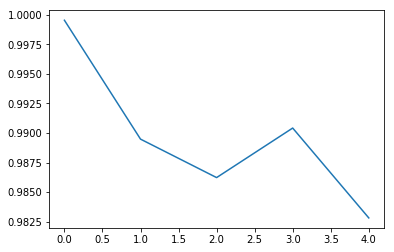

In [7]:
hidden_size = [256, 256]
batch_size = None
no_epochs = 100
single_head = False

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

coreset_size = 0
data_gen = SplitMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
    rand_from_batch, coreset_size, batch_size, single_head) # runs loop of tasks, trains/re-trains vcl, evaluates vcl
print(vcl_result)

# # Run random coreset VCL
# tf.reset_default_graph()
# tf.set_random_seed(12)
# np.random.seed(1)
#
# coreset_size = 40
# data_gen = SplitMnistGenerator()
# rand_vcl_result = vcl.run_vcl(hidden_size, no_epochs, data_gen,
#     coreset.rand_from_batch, coreset_size, batch_size, single_head)
# print(rand_vcl_result)
#
# # Run k-center coreset VCL
# tf.reset_default_graph()
# tf.set_random_seed(12)
# np.random.seed(1)
#
# data_gen = SplitMnistGenerator()
# kcen_vcl_result = vcl.run_vcl(hidden_size, no_epochs, data_gen,
#     coreset.k_center, coreset_size, batch_size, single_head)
# print(kcen_vcl_result)

# Plot average accuracy
vcl_avg = np.nanmean(vcl_result, 1)
# rand_vcl_avg = np.nanmean(rand_vcl_result, 1)
# kcen_vcl_avg = np.nanmean(kcen_vcl_result, 1)
plt.plot(vcl_avg)
plt.show()

In [8]:
vcl_avg

array([0.99952719, 0.98947956, 0.98622832, 0.99041535, 0.98281979])